In [1]:
import numpy as np
from astropy.table import Table
import astropy.units as u
import pandas as pd
from astropy.io import fits
import os
from glob import glob
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval
from matplotlib.patches import Rectangle
from stdatamodels.jwst import datamodels as dm
from stdatamodels.jwst.datamodels import SlitModel

from BNBG.Pipeline.BetterBackgroundSubtractStep import BetterBackgroundStep
from BNBG.utils.utils import getSourcePosition
from BNBG.utils.logger import logConsole

CRDS folder at /home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/CRDS
Logger loaded
CRDS folder at /home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/CRDS


In [2]:
IDS = (
	8393,
	21848,
	8554,
	20302
)

In [11]:
def keepIDS(filelist, i=3):
	id_list = np.array([int(os.path.basename(f).split("_")[i][1:]) for f in filelist])
	result = {}
	for idx in IDS:
		if idx in id_list:
			index = np.where(id_list == idx)[0][0]
			result[idx] = fits.open(filelist[index])
	return result

def getMultiSlitIds(filelist):
	result = {}
	files = {}
	for idx in IDS:
		print(f"\nSource ID : {idx}")
		print("-------------------")
		result[idx] = []
		files[idx] = []
		for _,f in enumerate(filelist):
			print(f"File ({_}/{len(filelist)}) : {os.path.dirname(f)}/{os.path.basename(f)}")
			f = fits.open(f)
			for hdu in f:
				if hdu.name == "SCI" and hdu.header["SOURCEID"] == idx:
					print("Found an HDU")
					result[idx] += [hdu]
					files[idx] += [filelist[_]] if filelist[_] not in files[idx] else []

	return result, files


basic_s2d = keepIDS(glob("/home/tim-dewachter/Documents/Thèse/CAPERS/V0.1/CAPERS_UDS_V0.1/P*/*s2d.fits"))
basic_x1d = keepIDS(glob("/home/tim-dewachter/Documents/Thèse/CAPERS/V0.1/CAPERS_UDS_V0.1/P*/*x1d.fits"))
basic_table = {}
for key,f in basic_x1d.items():
	basic_table[key] = Table.read(f,1)

bnbg_s2d = keepIDS(glob("/home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/mastDownload/JWST/CAPERS/P*/Final/*s2d.fits"),i=1)
bnbg_x1d = keepIDS(glob("/home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/mastDownload/JWST/CAPERS/P*/Final/*x1d.fits"),i=1)
bnbg_table = {}
for key,f in bnbg_x1d.items():
	bnbg_table[key] = Table.read(f,1)

stage2_cal,_ = getMultiSlitIds(glob("/home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/mastDownload/JWST/CAPERS/P*/*cal.fits"))
stage2_s2d,_ = getMultiSlitIds(glob("/home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/mastDownload/JWST/CAPERS/P*/*s2d.fits"))
stage2_bkg,_ = getMultiSlitIds(glob("/home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/mastDownload/JWST/CAPERS/P*/*bkg-BNBG.fits"))
stage2_sub,_ = getMultiSlitIds(glob("/home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/mastDownload/JWST/CAPERS/P*/*cal-BNBG.fits"))
#basic_cal,_ = getMultiSlitIds(glob("/home/tim-dewachter/Documents/Thèse/"))


Source ID : 8393
-------------------
File (0/96) : /home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/mastDownload/JWST/CAPERS/P1/jw06368022001_05101_00002_nrs2_cal.fits
File (1/96) : /home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/mastDownload/JWST/CAPERS/P1/jw06368022001_05101_00001_nrs1_cal.fits
File (2/96) : /home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/mastDownload/JWST/CAPERS/P1/jw06368023001_03101_00002_nrs1_cal.fits
File (3/96) : /home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/mastDownload/JWST/CAPERS/P1/jw06368024001_03101_00002_nrs1_cal.fits
File (4/96) : /home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/mastDownload/JWST/CAPERS/P1/jw06368023001_05101_00003_nrs2_cal.fits
File (5/96) : /home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/mastDownload/JWST/CAPERS/P1/jw06368022001_03101_00002_nrs2_cal.fits
File (6/96) : /home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/mastDownload/JWST/CAPERS/P1/jw063680

In [5]:
cal_list = glob("/home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/mastDownload/JWST/CAPERS/Test/*cal.fits")
cal_list = [dm.open(f) for f in cal_list]
s2d_list = glob("/home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/mastDownload/JWST/CAPERS/Test/*s2d.fits")
s2d_list = [dm.open(f) for f in s2d_list]

2025-03-20 11:53:32,244 - stpipe - INFO - [7065]  [BetterBackground] : Initializing Better Background NIRSpec
2025-03-20 11:53:32,245 - stpipe - INFO - [7065]  [BetterBackground] : Calculating Background for slit 74
2025-03-20 11:53:32,252 - stpipe - WARNING - [7065] /home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/BNBG/utils/utils.py:86: RuntimeWarning: All-NaN slice encountered
  distribution = np.nanmedian(data, axis=1)

2025-03-20 11:53:32,255 - stpipe - INFO - [7065]  [BetterBackground] : Source position is 6.48967074189607
2025-03-20 11:53:32,256 - stpipe - WARNING - [7065] /home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/BNBG/Pipeline/BetterBackgroundSubtractStep.py:348: RuntimeWarning: All-NaN slice encountered
  medianData = generic_filter(data, lambda x : np.nanmedian(x), size=self.kernelSize, mode="nearest")

2025-03-20 11:53:32,269 - stpipe - WARNING - [7065] /home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/BNBG/Pipeline/BetterBackgroundSubt

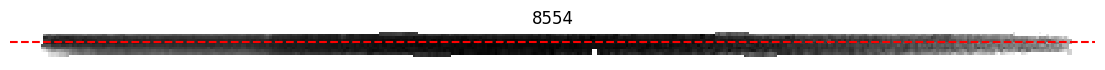

2025-03-20 11:53:32,320 - stpipe - INFO - [7065]  [BetterBackground] : Background Calculated!
2025-03-20 11:53:32,320 - stpipe - INFO - [7065]  [BetterBackground] : Initializing Better Background NIRSpec
2025-03-20 11:53:32,320 - stpipe - INFO - [7065]  [BetterBackground] : Calculating Background for slit 206
2025-03-20 11:53:32,326 - stpipe - INFO - [7065]  [BetterBackground] : Source position is 6.883878522088269


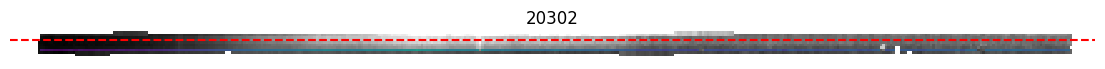

2025-03-20 11:53:32,396 - stpipe - INFO - [7065]  [BetterBackground] : Background Calculated!
2025-03-20 11:53:32,397 - stpipe - INFO - [7065]  [BetterBackground] : Initializing Better Background NIRSpec
2025-03-20 11:53:32,397 - stpipe - INFO - [7065]  [BetterBackground] : Calculating Background for slit 73
2025-03-20 11:53:32,405 - stpipe - INFO - [7065]  [BetterBackground] : Source position is 6.758184843973595


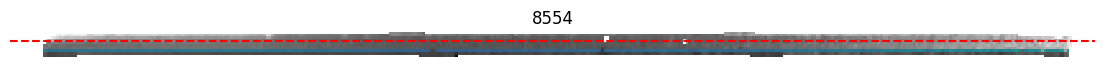

2025-03-20 11:53:32,458 - stpipe - INFO - [7065]  [BetterBackground] : Background Calculated!
2025-03-20 11:53:32,459 - stpipe - INFO - [7065]  [BetterBackground] : Initializing Better Background NIRSpec
2025-03-20 11:53:32,459 - stpipe - INFO - [7065]  [BetterBackground] : Calculating Background for slit 145
2025-03-20 11:53:32,464 - stpipe - WARNING - [7065] /home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/BNBG/utils/utils.py:98: OptimizeWarning: Covariance of the parameters could not be estimated
  coeff, err = curve_fit(lambda x, x0, s, A, c : A*np.exp(-(x-x0)**2/(2*s**2))+c,

2025-03-20 11:53:32,465 - stpipe - INFO - [7065]  [BetterBackground] : Source position is 5.388354959858221


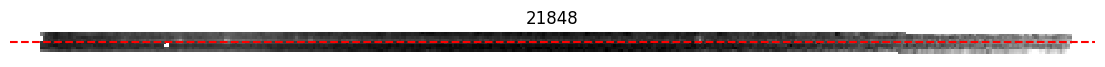

2025-03-20 11:53:32,512 - stpipe - INFO - [7065]  [BetterBackground] : Background Calculated!
2025-03-20 11:53:32,513 - stpipe - INFO - [7065]  [BetterBackground] : Calculating Background for slit 191
2025-03-20 11:53:32,518 - stpipe - INFO - [7065]  [BetterBackground] : Source position is 5.8712737363051355


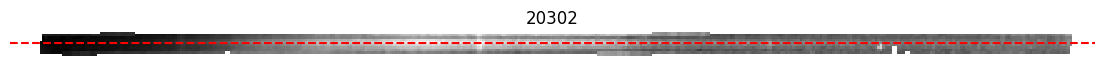

2025-03-20 11:53:32,566 - stpipe - INFO - [7065]  [BetterBackground] : Background Calculated!
2025-03-20 11:53:32,566 - stpipe - INFO - [7065]  [BetterBackground] : Initializing Better Background NIRSpec
2025-03-20 11:53:32,566 - stpipe - INFO - [7065]  [BetterBackground] : Calculating Background for slit 206
2025-03-20 11:53:32,571 - stpipe - INFO - [7065]  [BetterBackground] : Source position is 6.868370878007497


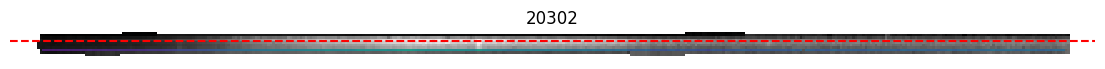

2025-03-20 11:53:32,626 - stpipe - INFO - [7065]  [BetterBackground] : Background Calculated!
2025-03-20 11:53:32,626 - stpipe - INFO - [7065]  [BetterBackground] : Initializing Better Background NIRSpec
2025-03-20 11:53:32,627 - stpipe - INFO - [7065]  [BetterBackground] : Calculating Background for slit 74
2025-03-20 11:53:32,632 - stpipe - INFO - [7065]  [BetterBackground] : Source position is 5.59895958811193


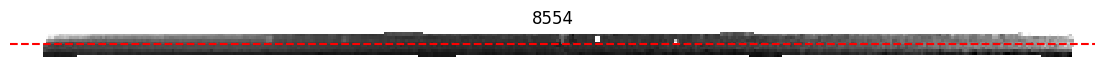

2025-03-20 11:53:32,683 - stpipe - INFO - [7065]  [BetterBackground] : Background Calculated!
2025-03-20 11:53:32,683 - stpipe - INFO - [7065]  [BetterBackground] : Initializing Better Background NIRSpec
2025-03-20 11:53:32,683 - stpipe - INFO - [7065]  [BetterBackground] : Calculating Background for slit 73
2025-03-20 11:53:32,688 - stpipe - INFO - [7065]  [BetterBackground] : Source position is 5.764427180880486


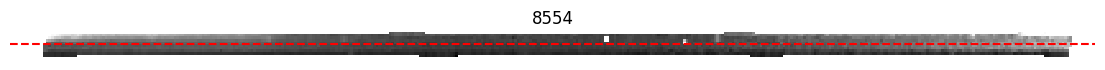

2025-03-20 11:53:32,740 - stpipe - INFO - [7065]  [BetterBackground] : Background Calculated!
2025-03-20 11:53:32,741 - stpipe - INFO - [7065]  [BetterBackground] : Initializing Better Background NIRSpec
2025-03-20 11:53:32,741 - stpipe - INFO - [7065]  [BetterBackground] : Calculating Background for slit 70
2025-03-20 11:53:32,747 - stpipe - INFO - [7065]  [BetterBackground] : Source position is 9.147350714522657


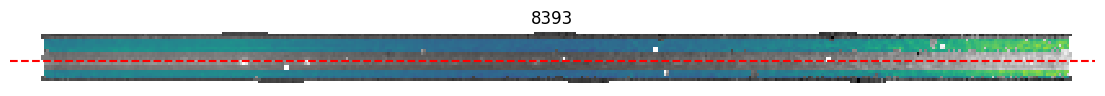

2025-03-20 11:53:32,891 - stpipe - INFO - [7065]  [BetterBackground] : Background Calculated!
2025-03-20 11:53:32,891 - stpipe - INFO - [7065]  [BetterBackground] : Initializing Better Background NIRSpec
2025-03-20 11:53:32,891 - stpipe - INFO - [7065]  [BetterBackground] : Calculating Background for slit 145
2025-03-20 11:53:32,896 - stpipe - INFO - [7065]  [BetterBackground] : Source position is 5.399931814151076


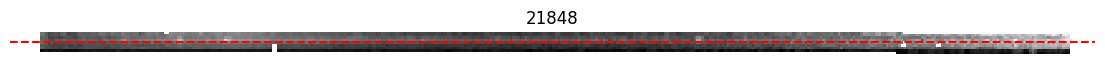

2025-03-20 11:53:32,946 - stpipe - INFO - [7065]  [BetterBackground] : Background Calculated!
2025-03-20 11:53:32,947 - stpipe - INFO - [7065]  [BetterBackground] : Calculating Background for slit 191
2025-03-20 11:53:32,952 - stpipe - INFO - [7065]  [BetterBackground] : Source position is 5.883952282131761


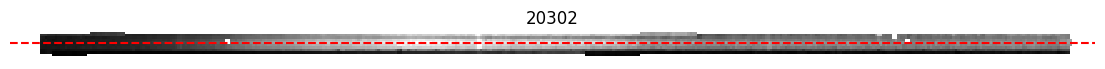

2025-03-20 11:53:33,244 - stpipe - INFO - [7065]  [BetterBackground] : Background Calculated!
2025-03-20 11:53:33,244 - stpipe - INFO - [7065]  [BetterBackground] : Initializing Better Background NIRSpec
2025-03-20 11:53:33,244 - stpipe - INFO - [7065]  [BetterBackground] : Calculating Background for slit 70
2025-03-20 11:53:33,251 - stpipe - INFO - [7065]  [BetterBackground] : Source position is 8.119158907726247


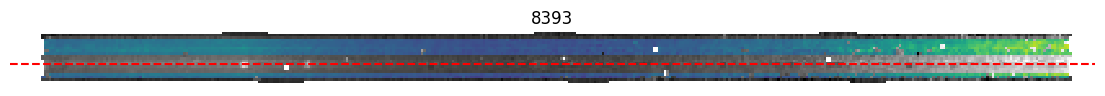

2025-03-20 11:53:33,380 - stpipe - INFO - [7065]  [BetterBackground] : Background Calculated!
2025-03-20 11:53:33,381 - stpipe - INFO - [7065]  [BetterBackground] : Initializing Better Background NIRSpec
2025-03-20 11:53:33,381 - stpipe - INFO - [7065]  [BetterBackground] : Calculating Background for slit 145
2025-03-20 11:53:33,389 - stpipe - INFO - [7065]  [BetterBackground] : Source position is 6.376352755368849


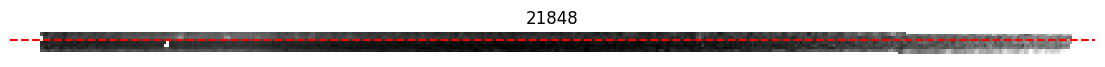

2025-03-20 11:53:33,472 - stpipe - INFO - [7065]  [BetterBackground] : Background Calculated!
2025-03-20 11:53:33,473 - stpipe - INFO - [7065]  [BetterBackground] : Calculating Background for slit 191
2025-03-20 11:53:33,482 - stpipe - INFO - [7065]  [BetterBackground] : Source position is 6.862561536241421


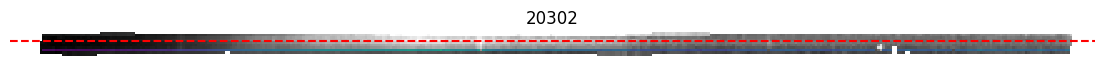

2025-03-20 11:53:33,569 - stpipe - INFO - [7065]  [BetterBackground] : Background Calculated!
2025-03-20 11:53:33,570 - stpipe - INFO - [7065]  [BetterBackground] : Initializing Better Background NIRSpec
2025-03-20 11:53:33,571 - stpipe - INFO - [7065]  [BetterBackground] : Calculating Background for slit 74
2025-03-20 11:53:33,578 - stpipe - INFO - [7065]  [BetterBackground] : Source position is 5.576419732816806


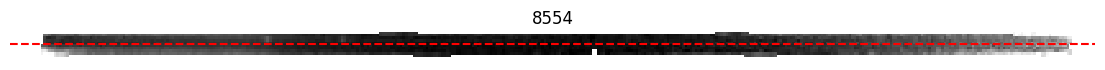

2025-03-20 11:53:33,625 - stpipe - INFO - [7065]  [BetterBackground] : Background Calculated!
2025-03-20 11:53:33,626 - stpipe - INFO - [7065]  [BetterBackground] : Initializing Better Background NIRSpec
2025-03-20 11:53:33,626 - stpipe - INFO - [7065]  [BetterBackground] : Calculating Background for slit 73
2025-03-20 11:53:33,631 - stpipe - INFO - [7065]  [BetterBackground] : Source position is 5.716499803966643


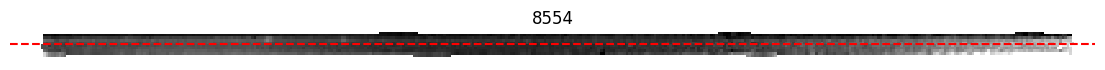

2025-03-20 11:53:33,680 - stpipe - INFO - [7065]  [BetterBackground] : Background Calculated!
2025-03-20 11:53:33,681 - stpipe - INFO - [7065]  [BetterBackground] : Initializing Better Background NIRSpec
2025-03-20 11:53:33,681 - stpipe - INFO - [7065]  [BetterBackground] : Calculating Background for slit 206
2025-03-20 11:53:33,686 - stpipe - INFO - [7065]  [BetterBackground] : Source position is 5.911747434050464


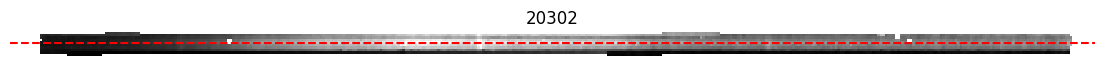

2025-03-20 11:53:33,735 - stpipe - INFO - [7065]  [BetterBackground] : Background Calculated!
2025-03-20 11:53:33,736 - stpipe - INFO - [7065]  [BetterBackground] : Initializing Better Background NIRSpec
2025-03-20 11:53:33,736 - stpipe - INFO - [7065]  [BetterBackground] : Calculating Background for slit 70
2025-03-20 11:53:33,745 - stpipe - INFO - [7065]  [BetterBackground] : Source position is 4.0727320741012125


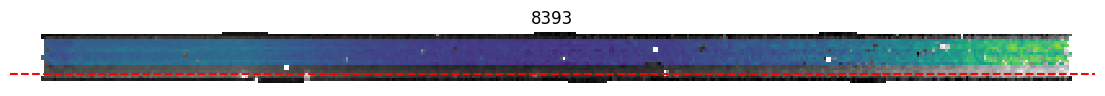

2025-03-20 11:53:33,903 - stpipe - INFO - [7065]  [BetterBackground] : Background Calculated!
2025-03-20 11:53:33,903 - stpipe - INFO - [7065]  [BetterBackground] : Initializing Better Background NIRSpec
2025-03-20 11:53:33,904 - stpipe - INFO - [7065]  [BetterBackground] : Calculating Background for slit 73
2025-03-20 11:53:33,912 - stpipe - INFO - [7065]  [BetterBackground] : Source position is 6.720419271933752


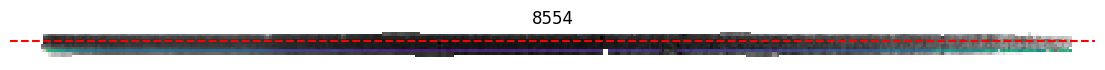

2025-03-20 11:53:33,972 - stpipe - INFO - [7065]  [BetterBackground] : Background Calculated!
2025-03-20 11:53:33,972 - stpipe - INFO - [7065]  [BetterBackground] : Initializing Better Background NIRSpec
2025-03-20 11:53:33,972 - stpipe - INFO - [7065]  [BetterBackground] : Calculating Background for slit 145
2025-03-20 11:53:33,977 - stpipe - INFO - [7065]  [BetterBackground] : Source position is 6.366580689729856


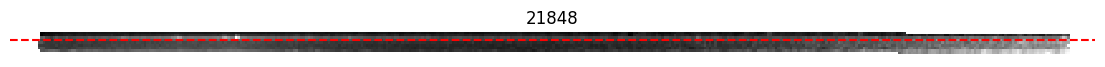

2025-03-20 11:53:34,025 - stpipe - INFO - [7065]  [BetterBackground] : Background Calculated!
2025-03-20 11:53:34,025 - stpipe - INFO - [7065]  [BetterBackground] : Calculating Background for slit 191
2025-03-20 11:53:34,030 - stpipe - INFO - [7065]  [BetterBackground] : Source position is 6.85023252878212


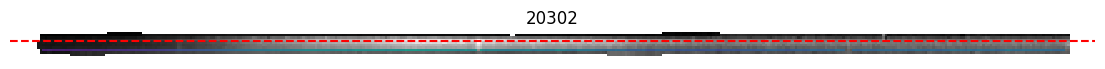

2025-03-20 11:53:34,094 - stpipe - INFO - [7065]  [BetterBackground] : Background Calculated!
2025-03-20 11:53:34,095 - stpipe - INFO - [7065]  [BetterBackground] : Initializing Better Background NIRSpec
2025-03-20 11:53:34,095 - stpipe - INFO - [7065]  [BetterBackground] : Calculating Background for slit 145
2025-03-20 11:53:34,100 - stpipe - INFO - [7065]  [BetterBackground] : Source position is 5.374127007477975


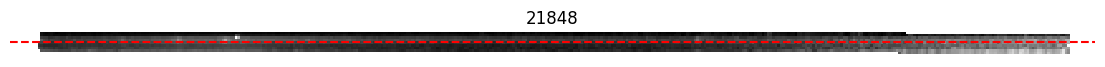

2025-03-20 11:53:34,151 - stpipe - INFO - [7065]  [BetterBackground] : Background Calculated!
2025-03-20 11:53:34,151 - stpipe - INFO - [7065]  [BetterBackground] : Calculating Background for slit 191
2025-03-20 11:53:34,156 - stpipe - INFO - [7065]  [BetterBackground] : Source position is 5.855163990559413


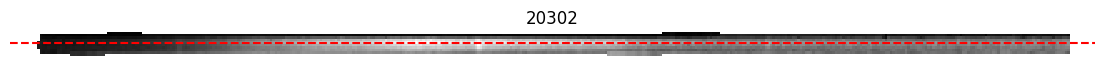

2025-03-20 11:53:34,210 - stpipe - INFO - [7065]  [BetterBackground] : Background Calculated!
2025-03-20 11:53:34,210 - stpipe - INFO - [7065]  [BetterBackground] : Initializing Better Background NIRSpec
2025-03-20 11:53:34,210 - stpipe - INFO - [7065]  [BetterBackground] : Calculating Background for slit 70
2025-03-20 11:53:34,216 - stpipe - INFO - [7065]  [BetterBackground] : Source position is 13.19620059881375


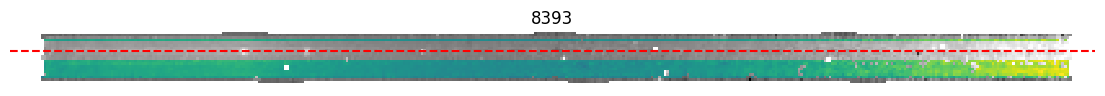

2025-03-20 11:53:34,358 - stpipe - INFO - [7065]  [BetterBackground] : Background Calculated!
2025-03-20 11:53:34,359 - stpipe - INFO - [7065]  [BetterBackground] : Initializing Better Background NIRSpec
2025-03-20 11:53:34,359 - stpipe - INFO - [7065]  [BetterBackground] : Calculating Background for slit 206
2025-03-20 11:53:34,365 - stpipe - INFO - [7065]  [BetterBackground] : Source position is 5.892409422795659


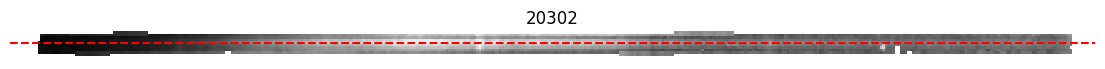

2025-03-20 11:53:34,422 - stpipe - INFO - [7065]  [BetterBackground] : Background Calculated!
2025-03-20 11:53:34,423 - stpipe - INFO - [7065]  [BetterBackground] : Initializing Better Background NIRSpec
2025-03-20 11:53:34,423 - stpipe - INFO - [7065]  [BetterBackground] : Calculating Background for slit 73
2025-03-20 11:53:34,428 - stpipe - INFO - [7065]  [BetterBackground] : Source position is 6.721868159214843


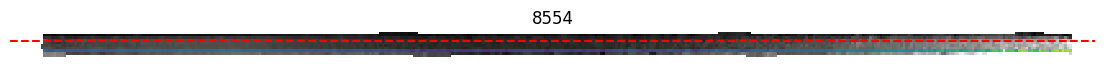

2025-03-20 11:53:34,488 - stpipe - INFO - [7065]  [BetterBackground] : Background Calculated!
2025-03-20 11:53:34,489 - stpipe - INFO - [7065]  [BetterBackground] : Initializing Better Background NIRSpec
2025-03-20 11:53:34,489 - stpipe - INFO - [7065]  [BetterBackground] : Calculating Background for slit 206
2025-03-20 11:53:34,499 - stpipe - INFO - [7065]  [BetterBackground] : Source position is 6.901839960911319


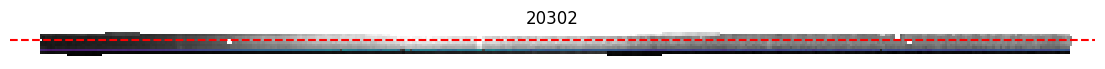

2025-03-20 11:53:34,564 - stpipe - INFO - [7065]  [BetterBackground] : Background Calculated!
2025-03-20 11:53:34,565 - stpipe - INFO - [7065]  [BetterBackground] : Initializing Better Background NIRSpec
2025-03-20 11:53:34,565 - stpipe - INFO - [7065]  [BetterBackground] : Calculating Background for slit 74
2025-03-20 11:53:34,570 - stpipe - INFO - [7065]  [BetterBackground] : Source position is 5.548841333818896


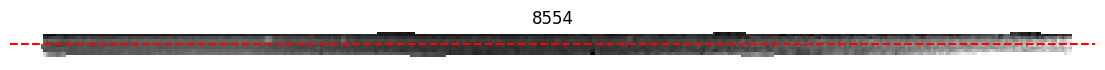

2025-03-20 11:53:34,629 - stpipe - INFO - [7065]  [BetterBackground] : Background Calculated!
2025-03-20 11:53:34,629 - stpipe - INFO - [7065]  [BetterBackground] : Initializing Better Background NIRSpec
2025-03-20 11:53:34,630 - stpipe - INFO - [7065]  [BetterBackground] : Calculating Background for slit 74
2025-03-20 11:53:34,635 - stpipe - INFO - [7065]  [BetterBackground] : Source position is 6.588118624768667


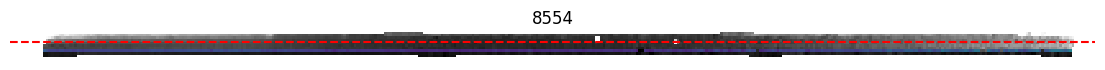

2025-03-20 11:53:34,698 - stpipe - INFO - [7065]  [BetterBackground] : Background Calculated!
2025-03-20 11:53:34,698 - stpipe - INFO - [7065]  [BetterBackground] : Initializing Better Background NIRSpec
2025-03-20 11:53:34,698 - stpipe - INFO - [7065]  [BetterBackground] : Calculating Background for slit 73
2025-03-20 11:53:34,703 - stpipe - INFO - [7065]  [BetterBackground] : Source position is 5.739669814178476


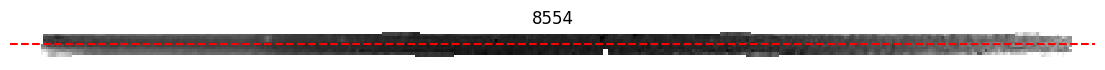

2025-03-20 11:53:34,757 - stpipe - INFO - [7065]  [BetterBackground] : Background Calculated!
2025-03-20 11:53:34,757 - stpipe - INFO - [7065]  [BetterBackground] : Initializing Better Background NIRSpec
2025-03-20 11:53:34,758 - stpipe - INFO - [7065]  [BetterBackground] : Calculating Background for slit 70
2025-03-20 11:53:34,763 - stpipe - INFO - [7065]  [BetterBackground] : Source position is 3.055402530208683


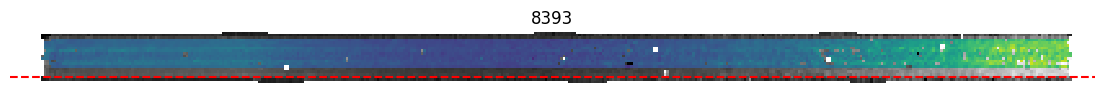

2025-03-20 11:53:34,925 - stpipe - INFO - [7065]  [BetterBackground] : Background Calculated!
2025-03-20 11:53:34,925 - stpipe - INFO - [7065]  [BetterBackground] : Initializing Better Background NIRSpec
2025-03-20 11:53:34,925 - stpipe - INFO - [7065]  [BetterBackground] : Calculating Background for slit 70
2025-03-20 11:53:34,931 - stpipe - INFO - [7065]  [BetterBackground] : Source position is 14.20703837977328


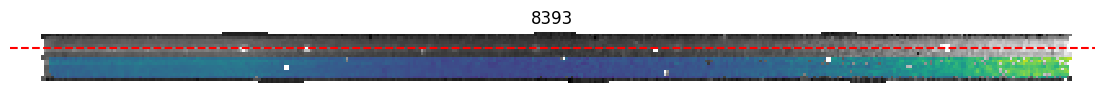

2025-03-20 11:53:35,075 - stpipe - INFO - [7065]  [BetterBackground] : Background Calculated!
2025-03-20 11:53:35,076 - stpipe - INFO - [7065]  [BetterBackground] : Initializing Better Background NIRSpec
2025-03-20 11:53:35,076 - stpipe - INFO - [7065]  [BetterBackground] : Calculating Background for slit 206
2025-03-20 11:53:35,081 - stpipe - INFO - [7065]  [BetterBackground] : Source position is 5.876739114345468


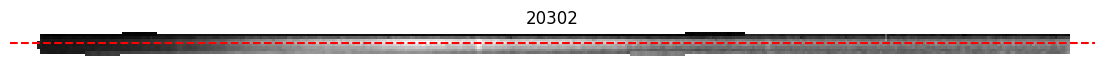

2025-03-20 11:53:35,133 - stpipe - INFO - [7065]  [BetterBackground] : Background Calculated!
2025-03-20 11:53:35,133 - stpipe - INFO - [7065]  [BetterBackground] : Initializing Better Background NIRSpec
2025-03-20 11:53:35,133 - stpipe - INFO - [7065]  [BetterBackground] : Calculating Background for slit 145
2025-03-20 11:53:35,138 - stpipe - INFO - [7065]  [BetterBackground] : Source position is 6.401767035997362


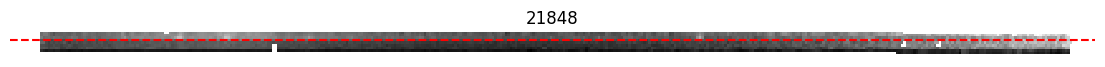

2025-03-20 11:53:35,186 - stpipe - INFO - [7065]  [BetterBackground] : Background Calculated!
2025-03-20 11:53:35,186 - stpipe - INFO - [7065]  [BetterBackground] : Calculating Background for slit 191
2025-03-20 11:53:35,193 - stpipe - INFO - [7065]  [BetterBackground] : Source position is 6.887136316218016


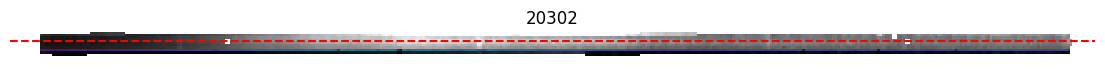

2025-03-20 11:53:35,249 - stpipe - INFO - [7065]  [BetterBackground] : Background Calculated!
2025-03-20 11:53:35,250 - stpipe - INFO - [7065]  [BetterBackground] : Initializing Better Background NIRSpec
2025-03-20 11:53:35,250 - stpipe - INFO - [7065]  [BetterBackground] : Calculating Background for slit 74
2025-03-20 11:53:35,257 - stpipe - INFO - [7065]  [BetterBackground] : Source position is 6.542182234981663


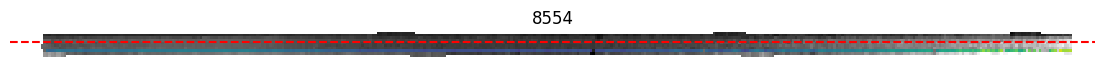

2025-03-20 11:53:35,313 - stpipe - INFO - [7065]  [BetterBackground] : Background Calculated!


In [6]:
for cal,s2d in zip(cal_list,s2d_list):
	step = BetterBackgroundStep(None, cal, s2d)
	for slit in s2d.slits:
		logConsole(f"Calculating Background for slit {slit.name}")

		s2dSlit = slit

		Y, X = np.indices(s2dSlit.data.shape)
		ra, dec, dataLambda = s2dSlit.meta.wcs.transform("detector", "world", X, Y)

		source = getSourcePosition(s2dSlit)

		data, error = s2dSlit.data.copy(), s2dSlit.err.copy()
		mask = step._cleanupImage(data.copy(), error.copy(), source=source)

		z1, z2 = ZScaleInterval().get_limits(data)
		plt.figure(figsize=(14,3))
		plt.imshow(data, origin="lower", vmin=z1, vmax=z2, interpolation="none", cmap="gray")
		data[mask] = np.nan
		plt.imshow(data, origin="lower", vmin=z1, vmax=z2, interpolation="none")
		plt.axhline(source, color='r', linestyle='--')
		plt.title(s2dSlit.source_id)
		plt.axis('off')
		plt.show()


		logConsole("Background Calculated!")

In [7]:
# Initialize a list to collect data efficiently
data = []

for s2d in s2d_list:
    for slit in s2d.slits:
        Y, X = np.indices(slit.data.shape)
        ra, dec, dataLambda = slit.meta.wcs.transform("detector", "world", X, Y)

        # Flatten and take the mean to store single values instead of lists
        data.append([
            slit.source_id,
            ra,
            dec,
			slit.source_ra,
			slit.source_dec,
            slit.slitlet_id,
            slit.shutter_id,
            slit.meta.observation.exposure_number,
            slit.meta.dither.position_number,
            slit.shutter_state
        ])

# Create DataFrame in one step
sky_pos = pd.DataFrame(data, columns=["id", "ra", "dec", "src_ra", "src_dec", "slitlet", "shutter", "exposure", "dither", "state"])

# Display DataFrame
display(sky_pos)

,id,ra,dec,src_ra,src_dec,slitlet,shutter,exposure,dither,state
0,8554,"[[34.2551658526419, 34.2551658526419, 34.25516...","[[-5.126449717677503, -5.126449717677503, -5.1...",34.255109,-5.126628,74,61914,2,1,x
1,20302,"[[34.46749773337261, 34.46749773337261, 34.467...","[[-5.175851979389412, -5.175851979389412, -5.1...",34.467380,-5.176041,206,53581,2,1,x
2,8554,"[[34.25516937615137, 34.25516937615137, 34.255...","[[-5.126442406875948, -5.126442406875948, -5.1...",34.255109,-5.126628,73,62279,4,3,x
3,21848,"[[34.48008859114973, 34.48008859114973, 34.480...","[[-5.182081133873735, -5.182081133873735, -5.1...",34.479993,-5.182229,145,50109,1,1,x
4,20302,"[[34.46748890153233, 34.46748890153233, 34.467...","[[-5.175879770499386, -5.175879770499386, -5.1...",34.467380,-5.176041,191,53581,1,1,x
5,20302,"[[34.46749663536088, 34.46749663536088, 34.467...","[[-5.175852382752187, -5.175852382752187, -5.1...",34.467380,-5.176041,206,53216,3,2,x
6,8554,"[[34.25515591099257, 34.25515591099257, 34.255...","[[-5.126474216171849, -5.126474216171849, -5.1...",34.255109,-5.126628,74,62279,3,3,x
7,8554,"[[34.25515879456554, 34.25515879456554, 34.255...","[[-5.126469709089719, -5.126469709089719, -5.1...",34.255109,-5.126628,73,62279,3,3,x
8,8393,"[[34.459925924522956, 34.459925924522956, 34.4...","[[-5.125759943996123, -5.125759943996123, -5.1...",34.459822,-5.126008,70,20258,2,1,1x1
9,21848,"[[34.48008912461451, 34.48008912461451, 34.480...","[[-5.182080833702147, -5.182080833702147, -5.1...",34.479993,-5.182229,145,50474,3,3,x


1x1


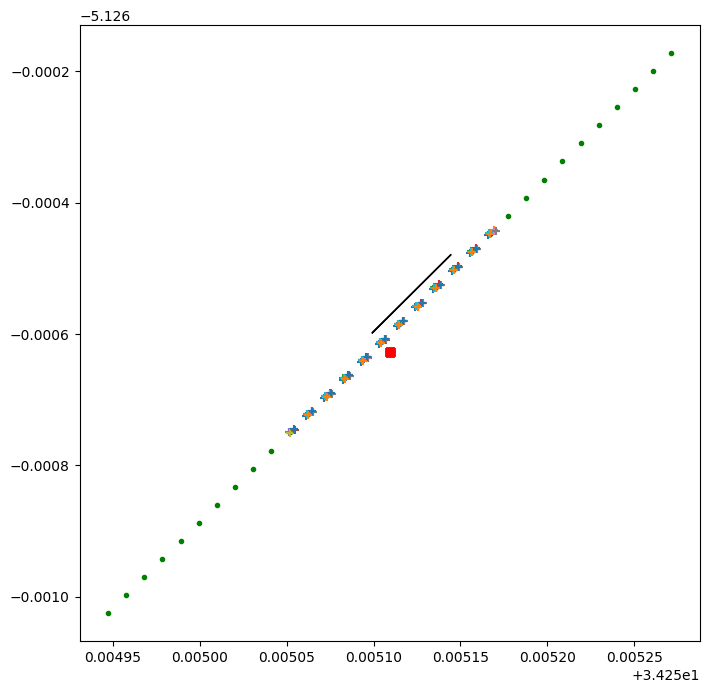

7.848721556585107


In [31]:
plt.figure(figsize=(8,8))
for _, row in sky_pos.iterrows():
	if row["id"] == 8554:
		plt.scatter(row["ra"][:,0], row["dec"][:,0], marker='+')
		plt.scatter(row["src_ra"], row["src_dec"], color='r', marker='s', zorder=3)

s2d = dm.open("/home/tim-dewachter/Documents/Thèse/BetterNIRSpecBackground/mastDownload/JWST/CAPERS/P3/Final/jw06368-o030_s000008554_nirspec_clear-prism_s2d.fits")
print(s2d.shutter_state)
Y, X = np.indices(s2d.data.shape)
ra, dec, dataLambda = s2d.meta.wcs.transform("detector", "world", X, Y)
plt.scatter(ra[:,0], dec[:,0], color='g', marker='.', zorder=-2)

x0,x1 = plt.gcf().gca().get_xlim()
y0,y1 = plt.gcf().gca().get_ylim()

rect = Rectangle(((x0+x1)/2-0.00001, (y0+y1)/2), 0.46/3600, 0.001/3600, angle=180/np.pi*np.atan((y1-y0)/(x1-x0)), color='k')
plt.gca().add_patch(rect)

plt.show()

L = np.sqrt((y0-y1)**2 + (x0-x1)**2)
print(L/0.46*3600)